In [1]:
pip install snap-stanford

Note: you may need to restart the kernel to use updated packages.


In [82]:
import snap
import pandas as pd
from datetime import datetime

In [89]:
file_path = "soc-redditHyperlinks-body.tsv"
df = pd.read_csv(file_path, sep='\t')

def preprocess_data(df):
    # Convert TIMESTAMP column to datetime format
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])

    # Create a new column for the year
    df['Year'] = df['TIMESTAMP'].dt.year

    return df

In [90]:
def preprocess_data(df):
    # Convert TIMESTAMP column to datetime format
    df['TIMESTAMP'] = pd.to_datetime(df['TIMESTAMP'])

    # Create a new column for the year
    df['Year'] = df['TIMESTAMP'].dt.year

    return df

def create_graph(df, year):
    # Filter data for the specified year
    year_df = df[df['Year'] == year]

    # Create a directed graph
    G = snap.TNGraph.New()

    # Add nodes and edges to the graph
    for index, row in year_df.iterrows():
        source_node = row['SOURCE_SUBREDDIT']
        target_node = row['TARGET_SUBREDDIT']
        
        # Convert node IDs to integers. Hashfunction handles large integer values
        source_node_id = hash(source_node) % (2**31 - 1)
        target_node_id = hash(target_node) % (2**31 - 1)

      # Add nodes if not already present
        if not G.IsNode(int(source_node_id)):
            G.AddNode(int(source_node_id))
        if not G.IsNode(int(target_node_id)):
            G.AddNode(int(target_node_id))

        # Add directed edge
        G.AddEdge(int(source_node_id), int(target_node_id))

    return G

# Preprocess data
df = preprocess_data(df)

# Specify the range of years in your dataset
start_year = 2014
end_year = 2017


for year in range(start_year, end_year + 1):
    # Create a graph for the specified year
    graph = create_graph(df, year)
    
    # Save the graph to a file (optional)
    snap.SaveEdgeList(graph, f"graph_{year}.txt", "Graph for Year " + str(year))

In [91]:
# PRUNING - removing nodes with low out degrees

import snap
import numpy as np

# Function to prune the graph based on degree distribution
def prune_graph(graph, percentile):
    # Get the degrees of all nodes in the graph
    degrees = [node.GetOutDeg() for node in graph.Nodes()]
    
    # Calculate the threshold based on the specified percentile
    threshold = np.percentile(degrees, percentile)
    
    # Identify nodes to remove based on the threshold
    nodes_to_remove = [node.GetId() for node in graph.Nodes() if node.GetOutDeg() < threshold]
    
    # Remove identified nodes
    for node_id in nodes_to_remove:
        graph.DelNode(node_id)
    
    return graph

# Function to load graph from edge list text file

def load_graph_from_edge_list(file_path):
    # Create an empty directed graph
    graph = snap.TNGraph.New()
    
    # Load edges from the text file
    with open(file_path, 'r') as file:
        for line in file:
            
            if line.startswith('#'):
                continue
            
            source_node, target_node = map(int, line.strip().split('\t'))
            
            # Add nodes if not already present
            if not graph.IsNode(source_node):
                graph.AddNode(source_node)
            if not graph.IsNode(target_node):
                graph.AddNode(target_node)
            
            # Add directed edge
            graph.AddEdge(source_node, target_node)
    
    return graph


# Prune graphs for each year
start_year = 2014
end_year = 2017

# Prune graphs for each year and save pruned graphs
pruned_graphs = {}
for year in range(start_year, end_year + 1):
    # Load the graph from the edge list file
    file_path = f"graph_{year}.txt"
    graph = load_graph_from_edge_list(file_path)
    
    # Prune the graph - 5th percentile threshold
    pruned_graph = prune_graph(graph, 5)  
    
    # Save the pruned graph to a file (optional)
    pruned_file_path = f"pruned_graph_{year}.txt"
    snap.SaveEdgeList(pruned_graph, pruned_file_path, f"Pruned Graph for Year {year}")
    
    pruned_graphs[year] = pruned_graph

In [8]:
pip install python-louvain

Note: you may need to restart the kernel to use updated packages.


In [9]:
pip install python-igraph

Note: you may need to restart the kernel to use updated packages.


In [10]:
pip install --upgrade python-igraph

Note: you may need to restart the kernel to use updated packages.


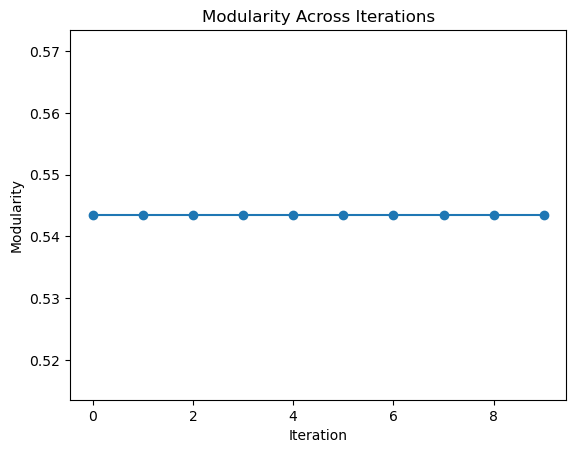

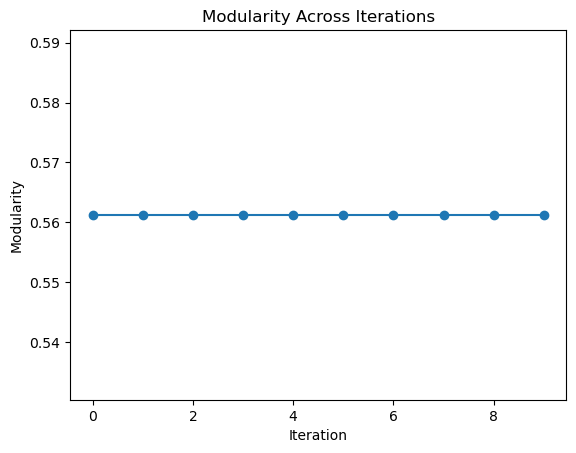

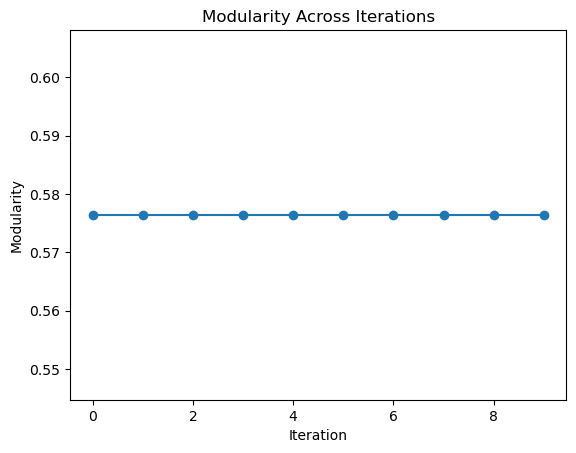

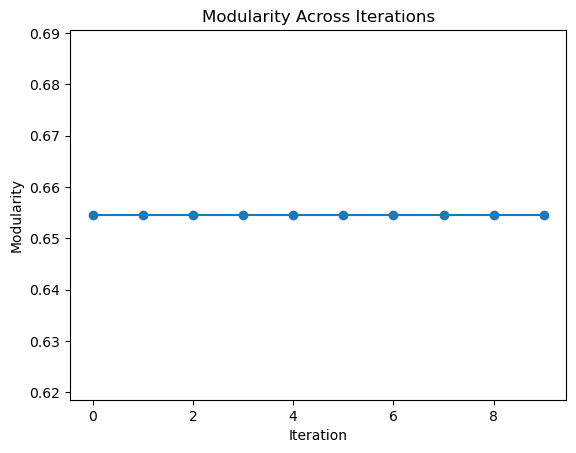

In [103]:
import snap
import networkx as nx
import community
import random
import matplotlib.pyplot as plt

random.seed(42) 

# Load pruned graph
def load_pruned_graph_from_edge_list(file_path):
    graph = nx.Graph()  # Use undirected graph
    all_node_ids = set()

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue

            source_node, target_node = map(int, line.strip().split('\t'))

            graph.add_edge(source_node, target_node)
            all_node_ids.update([source_node, target_node])

    return graph, list(all_node_ids)


def load_communities_louvain_with_plot(graph, seed=42, num_iterations=10):
    best_partition = None
    best_modularity = float('-inf')
    modularity_values = []

    for _ in range(num_iterations):
        partition = community.best_partition(graph, random_state=seed)
        modularity = community.modularity(partition, graph)
        modularity_values.append(modularity)

        if modularity > best_modularity:
            best_partition = partition
            best_modularity = modularity

    communities = {}
    for node, comm_id in best_partition.items():
        if comm_id not in communities:
            communities[comm_id] = [node]
        else:
            communities[comm_id].append(node)

    # Plot modularity values
    plt.plot(modularity_values, marker='o')
    plt.xlabel('Iteration')
    plt.ylabel('Modularity')
    plt.title('Modularity Across Iterations')
    plt.show()

    return communities


# Find overlaps between communities across years for a given node
def find_community_overlaps(communities, node_id):
    community_memberships = {year: set() for year in communities.keys()}

    for year, year_communities in communities.items():
        for community_idx, nodes in year_communities.items():
            if node_id in nodes:
                community_memberships[year].add(community_idx)

    return community_memberships

# Load communities for each year
def load_communities(start_year, end_year):
    all_communities = {}
    all_node_ids = set()

    for year in range(start_year, end_year + 1):
        file_path = f"pruned_graph_{year}.txt"
        graph, nodes = load_pruned_graph_from_edge_list(file_path)
        all_node_ids.update(nodes)

        year_communities = load_communities_louvain_with_plot(graph)
        all_communities[year] = year_communities

    return all_communities, list(all_node_ids)

# Specify the range of years in your dataset
start_year = 2014
end_year = 2017

# Load communities for each year
communities, all_node_ids = load_communities(start_year, end_year)

# Write communities to a file
with open("communities.txt", "w") as communities_file:
    for year, year_communities in communities.items():
        communities_file.write(f"Year {year} communities:\n")
        for community_idx, nodes in year_communities.items():
            communities_file.write(f"Community {community_idx}: {nodes}\n")
        communities_file.write("\n")


In [101]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


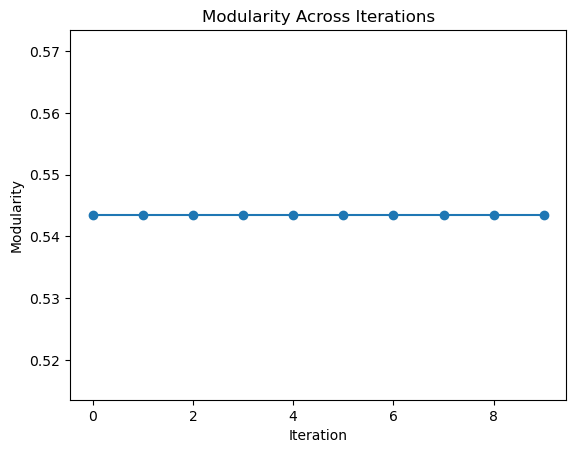

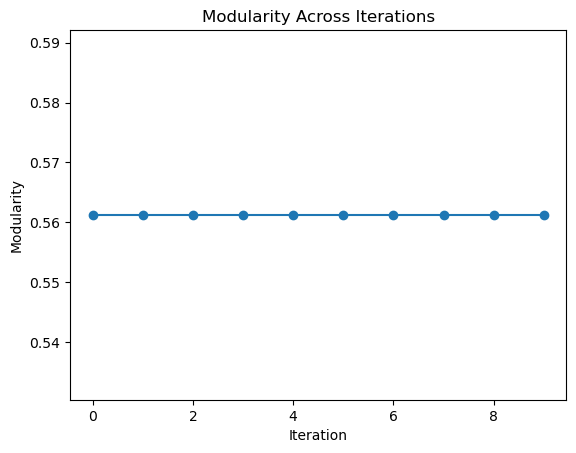

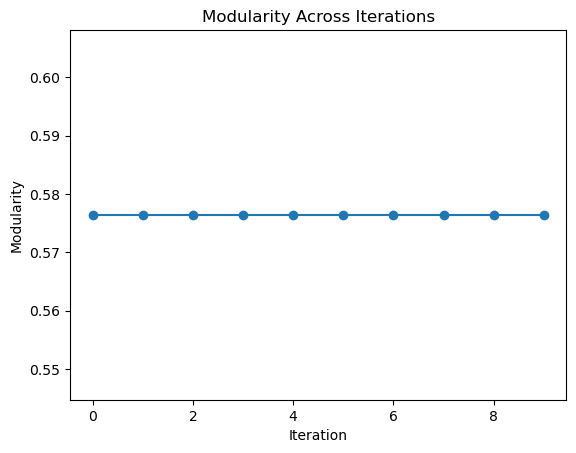

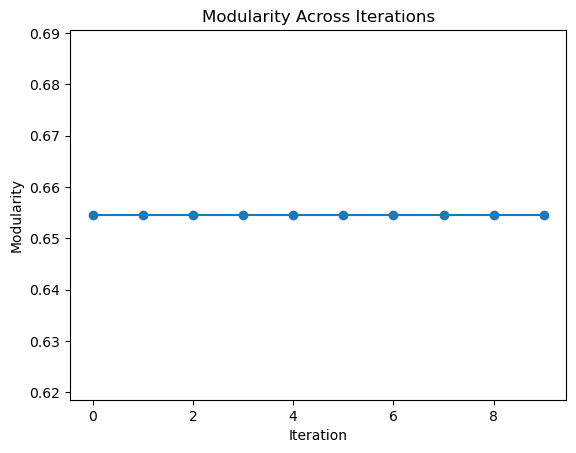

In [117]:
# MANUALLY MINING COMMUNITY GROUPS

def write_node_communities(nodes, communities, output_file):
    with open(output_file, "w") as file:
        for node_id in nodes:
            file.write(f"Node {node_id}:\n")
            for year, year_communities in communities.items():
                file.write(f"  Year {year} Communities: ")
                node_belongs_to_communities = [
                    comm_idx for comm_idx, nodes in year_communities.items() if node_id in nodes
                ]
                file.write(f"{node_belongs_to_communities}\n")

# Example usage
start_year = 2014
end_year = 2017

# Load communities for each year
communities, all_node_ids = load_communities(start_year, end_year)

# Specify the output file
output_file = "node_communities.txt"

# Write node communities to the file
write_node_communities(all_node_ids, communities, output_file)


In [118]:
from collections import Counter
from itertools import combinations

def mine_frequent_community_sets(input_file, threshold=2):
    community_sets = []

    with open(input_file, "r") as file:
        lines = file.readlines()

        for line in lines:
            if line.startswith("Node"):
                # Extract community sets for each year
                year_communities = [int(comm_idx) for comm_idx in line.split(":")[1].split()]
                
                print(f"Node communities for the year: {year_communities}")

                # Add unique combinations of community sets to the list
                for subset_size in range(1, len(year_communities) + 1):
                    community_sets.extend(combinations(year_communities, subset_size))

    # Count occurrences of each community set
    community_set_counts = Counter(community_sets)

    # Filter frequent community sets (adjust the threshold as needed)
    frequent_community_sets = {k: v for k, v in community_set_counts.items() if v >= threshold}

    return frequent_community_sets

# Example usage
input_file = "node_communities.txt"
threshold = 2  # Adjust the threshold as needed
frequent_sets = mine_frequent_community_sets(input_file, threshold)

# Print the frequent community sets
print(f"Frequently co-occurring community sets (appearing together at least {threshold} times):")
for community_set, count in frequent_sets.items():
    print(f"Community Set: {community_set}, Count: {count}")


Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communities for the year: []
Node communiti

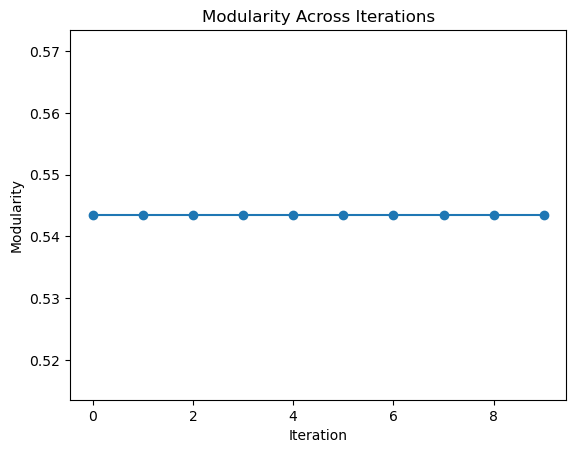

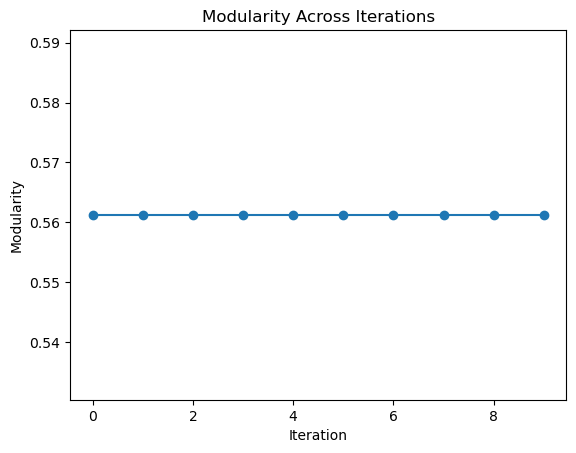

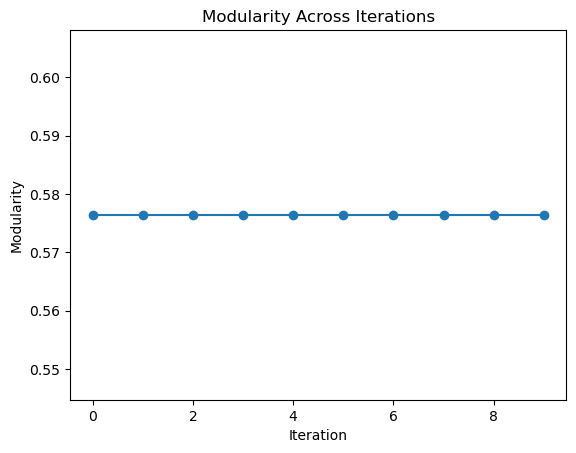

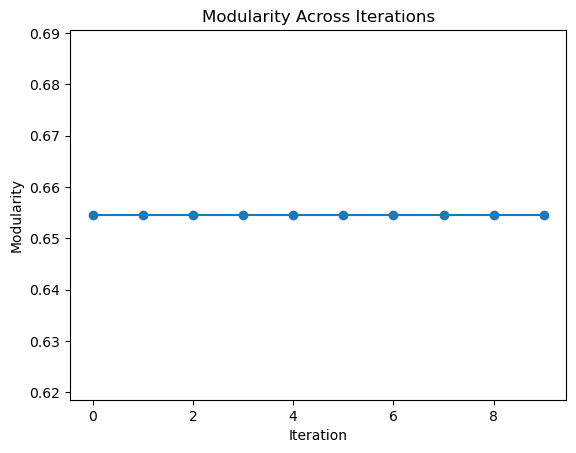

In [104]:
import nltk

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union if union != 0 else 0

def find_community_overlaps_all_years(communities, min_community_size=2, threshold=0.1):
    overlaps = {}

    years = sorted(communities.keys())
    num_years = len(years)

    for i in range(num_years - 2):  # Iterate up to the third-to-last year
        for j in range(i + 1, num_years - 1):  # Iterate up to the second-to-last year
            for k in range(j + 1, num_years):  # Iterate over the last year

                year1, year2, year3 = years[i], years[j], years[k]

                for comm_idx1, nodes1 in communities[year1].items():
                    if len(nodes1) < min_community_size:
                        continue

                    for comm_idx2, nodes2 in communities[year2].items():
                        if len(nodes2) < min_community_size:
                            continue
                        

                        jaccard_similarity1 = jaccard_similarity(set(nodes1), set(nodes2))

                        for comm_idx3, nodes3 in communities[year3].items():
                            if len(nodes3) < min_community_size:
                                continue
                                
                            

                            jaccard_similarity2 = jaccard_similarity(set(nodes1), set(nodes3))
                            jaccard_similarity3 = jaccard_similarity(set(nodes2), set(nodes3))

                            average_similarity = (jaccard_similarity1 + jaccard_similarity2 + jaccard_similarity3) / 3

                            if average_similarity >= threshold:
                                if (year1, comm_idx1) not in overlaps:
                                    overlaps[(year1, comm_idx1)] = []
                                overlaps[(year1, comm_idx1)].append((year2, comm_idx2, year3, comm_idx3))

    return overlaps

# Example usage
start_year = 2014
end_year = 2017

# Load communities for each year
communities, all_node_ids = load_communities(start_year, end_year)

# Find community overlaps with filtering
overlaps = find_community_overlaps_all_years(communities, min_community_size=5, threshold=0.5)

# Print the results
for key, value in overlaps.items():
    print(f"Community {key} overlaps with: {value}")


In [63]:
print(type(communities))

<class 'set'>


In [65]:
pip install nltk

Note: you may need to restart the kernel to use updated packages.


In [76]:
# JACCARD SIMILARITY DIDNT WORK so manual approach

In [80]:
print(communities)

{2014: {17: [1212297454, 1026390623, 822493069, 301887371, 418122735, 981791915, 1350451975, 1943917352, 2093174616, 4375156, 181857305, 1725499285, 2082430798, 1297371971, 77089342, 1184633355, 317554990, 371134309, 1256302431, 313772683, 340175629, 1041767100, 1410248044, 1579384009, 841983265, 2014699781, 1425764477, 320918810, 531196863, 1450627257, 1866529143, 2115381466, 1314262029, 1105509041, 1337573584, 728715888, 262386635, 160510380, 383060846, 1545134526, 479033400, 1479936127, 1894991917, 811605303, 2021956199, 1000964618, 3979840, 302536987, 1149798606, 605989907, 667005317, 129073379, 1758202634, 368663822, 1450086755, 1464378346, 1756164017, 1827900184, 1990850250, 248107725, 1560939466, 1058373268, 2076457629, 1547872573, 1311936640, 1971407543, 1863407065, 1973556431, 92239965, 447181262, 684447492, 1709255393, 1883573631, 1887985736, 2102072896, 1415233724, 1897271033, 757210439, 1865556975, 891380390, 109327819, 528671590, 553701129, 908089380, 1056473978, 105666929

In [97]:
#SCRAP

import snap

# Load pruned graph
def load_pruned_graph_from_edge_list(file_path):
    graph = snap.TNGraph.New()
    all_node_ids = set()

    with open(file_path, 'r') as file:
        for line in file:
            if line.startswith('#'):
                continue

            source_node, target_node = map(int, line.strip().split('\t'))

            if not graph.IsNode(source_node):
                graph.AddNode(source_node)
                all_node_ids.add(source_node)
            if not graph.IsNode(target_node):
                graph.AddNode(target_node)
                all_node_ids.add(target_node)

            graph.AddEdge(source_node, target_node)

    return graph, list(all_node_ids)

# Find overlaps between communities across years for a given node
def find_community_overlaps(communities, node_id):
    community_memberships = {year: set() for year in communities.keys()}

    for year, year_communities in communities.items():
        for community_idx, nodes in year_communities.items():
            if node_id in nodes:
                community_memberships[year].add(community_idx)

    return community_memberships

# Load communities for each year
def load_communities(start_year, end_year):
    communities = {}

    for year in range(start_year, end_year + 1):
        file_path = f"pruned_graph_{year}.txt"
        graph, all_node_ids = load_pruned_graph_from_edge_list(file_path)
        
        communities[year] = algorithm_for_dynamic_detection(graph)

    return communities, all_node_ids

# Dynamic community detection algorithm
def algorithm_for_dynamic_detection(graph, num_iterations=10):
    timestamp_communities = {}

    for iteration in range(num_iterations):
        for edge in graph.Edges():
            u, v, timestamp = edge.GetSrcNId(), edge.GetDstNId(), iteration

            u_community = timestamp_communities.setdefault(timestamp, {}).get(u, u)
            v_community = timestamp_communities.setdefault(timestamp, {}).get(v, v)

            if u_community != v_community:
                u_community_nodes = [node for node, comm in timestamp_communities[timestamp].items() if comm == u_community]
                v_community_nodes = [node for node, comm in timestamp_communities[timestamp].items() if comm == v_community]

                merged_community = min(u_community, v_community)
                for node in u_community_nodes + v_community_nodes:
                    timestamp_communities[timestamp][node] = merged_community

    return timestamp_communities

# Specify the range of years in your dataset
start_year = 2014
end_year = 2017

# Load communities for each year
communities, all_node_ids = load_communities(start_year, end_year)

# Iterate over all nodes and find community overlaps
node_community_overlaps = {}

for node_id in all_node_ids:
    community_overlaps = find_community_overlaps(communities, node_id)
    node_community_overlaps[node_id] = community_overlaps

# Print or process the results
for node_id, overlaps in node_community_overlaps.items():
    for year, communities in overlaps.items():
        print(f"Node {node_id} in Year {year} belongs to communities: {communities}")

# Optionally, you can check for overlaps between communities across years
for community_idx in range(max_community_index):  # Replace with the actual maximum community index
    community_overlap_years = []

    for year, year_communities in communities.items():
        if community_idx in year_communities:
            community_overlap_years.append(year)

    if len(community_overlap_years) > 1:
        print(f"Community {community_idx} overlaps in years: {community_overlap_years}")


Node 2025750531 in Year 2014 belongs to communities: set()
Node 2025750531 in Year 2015 belongs to communities: set()
Node 2025750531 in Year 2016 belongs to communities: set()
Node 2025750531 in Year 2017 belongs to communities: set()
Node 1668546565 in Year 2014 belongs to communities: set()
Node 1668546565 in Year 2015 belongs to communities: set()
Node 1668546565 in Year 2016 belongs to communities: set()
Node 1668546565 in Year 2017 belongs to communities: set()
Node 1832779788 in Year 2014 belongs to communities: set()
Node 1832779788 in Year 2015 belongs to communities: set()
Node 1832779788 in Year 2016 belongs to communities: set()
Node 1832779788 in Year 2017 belongs to communities: set()
Node 1331822620 in Year 2014 belongs to communities: set()
Node 1331822620 in Year 2015 belongs to communities: set()
Node 1331822620 in Year 2016 belongs to communities: set()
Node 1331822620 in Year 2017 belongs to communities: set()
Node 1488224285 in Year 2014 belongs to communities: set

Node 728715888 in Year 2014 belongs to communities: set()
Node 728715888 in Year 2015 belongs to communities: set()
Node 728715888 in Year 2016 belongs to communities: set()
Node 728715888 in Year 2017 belongs to communities: set()
Node 510644848 in Year 2014 belongs to communities: set()
Node 510644848 in Year 2015 belongs to communities: set()
Node 510644848 in Year 2016 belongs to communities: set()
Node 510644848 in Year 2017 belongs to communities: set()
Node 1265160818 in Year 2014 belongs to communities: set()
Node 1265160818 in Year 2015 belongs to communities: set()
Node 1265160818 in Year 2016 belongs to communities: set()
Node 1265160818 in Year 2017 belongs to communities: set()
Node 2126172785 in Year 2014 belongs to communities: set()
Node 2126172785 in Year 2015 belongs to communities: set()
Node 2126172785 in Year 2016 belongs to communities: set()
Node 2126172785 in Year 2017 belongs to communities: set()
Node 1799508596 in Year 2014 belongs to communities: set()
Node 

NameError: name 'max_community_index' is not defined